In [1]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate_days = 0.0001#0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

865it [00:32, 26.66it/s]                                                                                               


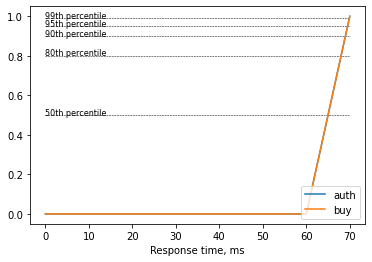

<Figure size 432x288 with 0 Axes>

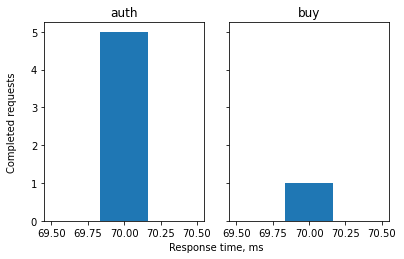

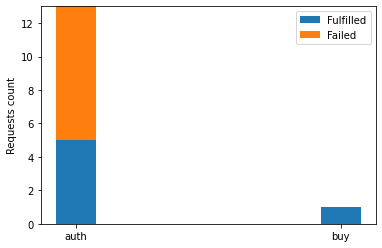

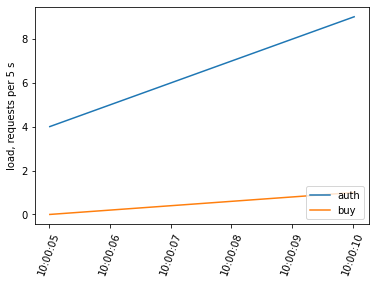

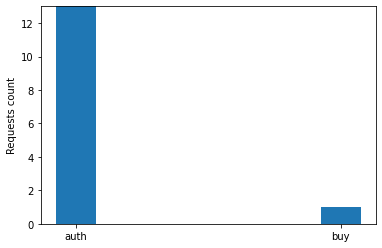

<Figure size 432x288 with 0 Axes>

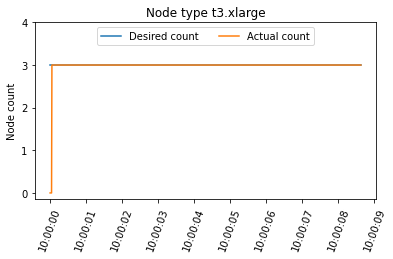

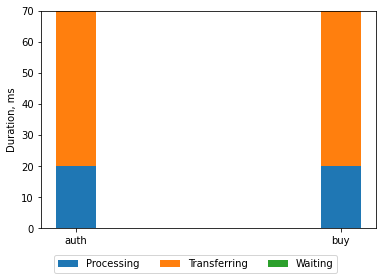

In [2]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')

In [7]:
from collections import deque

r = deque([])
r.appendleft(1)
r.appendleft(8)
r

deque([8, 1])

In [1]:
import collections

counter = collections.Counter([1, 1, 2, 3, 4, 1, 2, 4, 6])
for elem, count in counter.items():
    print("{}: {}".format(elem, count))
    
dd = collections.defaultdict(list)
dd[1].append(1)
dd

Point = collections.namedtuple('Point', {'x', 'y'})
r = Point(1 ,20)
r.x

a = (item for item in range(5))
for item in a:
    print(item)
    
def gen():
    yield 1
    yield 2
    
g = gen()
print(next(g))
print(next(g))
print(next(g))

1: 3
2: 2
3: 1
4: 2
6: 1
0
1
2
3
4
1
2


StopIteration: 

In [3]:
from functools import wraps

def cached(limit):
    
    def decorator(func):
        cache = {}
        
        @wraps(func)
        def new_func(x):
            
            if x not in cache:
                if len(cache) == limit:
                    del cache[list(cache.keys())[0]]
                cache[x] = func(x)
                print(cache)

            return cache[x]

        return new_func
    
    return decorator

@cached(limit = 3)
def half(x):
    return x / 2

half.__name__

'half'

In [5]:
class Message:
    
    _REGISTRY = {}
    
    @classmethod
    def register(cls, name):
        def decorator(klass):
            cls._REGISTRY[name] = klass
            return klass
        return decorator
    
    @classmethod
    def create(cls, message_type):
        klass = cls._REGISTRY[message_type]
        return klass()
    
@Message.register('telegram')
class Telegram(Message):
    def send(self):
        print('telegram')
        
msg = Message.create('telegram')
msg.send()

telegram


In [15]:
class A:
    
    y = 6
    
    @classmethod
    def new(cls, x):
        u = cls()
        u.x = x
        return u
    
    def get_x(self):
        return self.x
    
a = A.new(5)
b = A.new(7)
print(f"{a.x} and {b.x}")

7 and 7


In [8]:
import collections

x = pd.DataFrame({'datetime': [1,2,3], 'value': [4, 5, 6]}).set_index('datetime')
x1 = pd.DataFrame(columns = [x.index.name] + x.columns.to_list()).set_index(x.index.name)
converted_vals_marked = collections.defaultdict(list)
converted_vals_marked.update((k, []) for k in ([x.index.name] + x.columns.to_list()))
for ts, row in x.iterrows():
    converted_vals = [A(row_elem) for row_elem in row]
    for colname, val in zip(x.columns.to_list(), converted_vals):
        converted_vals_marked[colname].append(val)
    converted_vals_marked[x.index.name].append(ts)

xx = pd.DataFrame(converted_vals_marked).set_index(x.index.name)
    
max(xx['value']).x

6

In [12]:
import calendar


dd = {month: index for index, month in enumerate(calendar.month_abbr) if month}
'Dec' in dd

True

In [3]:
import pandas as pd

class A:
    def __init__(self, x):
        self.x = x
        
    def __mul__(self, other):
        return A(self.x * other)
    
    def __gt__(self, other):
        if self.x > other.x:
            return self
        else:
            return other

df1 = pd.DataFrame(data = {'index': [1,2,3], 'val': [A(1), A(5), A(13)]})
df1 = df1.set_index('index')
df2 = df1 * 5

for i, r in df2.iterrows():
    print(r[0].x)

5
25
65


In [4]:
class A:
    
    def __init__(self,
                 x, y = 0):
        
        self.x = x
        
    def __add__(self, other):
        
        return A(self.x + other.x)
    
    def __radd__(self, other):
        return other + self.x
        
sum([A(2), A(4), A(7)])

13

In [ ]:
import copy

class A:
    def __init__(self,
                 x):
        
        self.x = x
        
    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, copy.deepcopy(v, memo))
            
        return result
        
a = A(9)
b = copy.deepcopy(a)
b.x

In [ ]:
class B:
    def __init__(self):
        self.t = 5

class A:
    def __init__(self, x):
        self._x = x
        
    def upd(self, x):
        t = self
        t.x = x
        return self.x
    
    def __iter__(self):
        return AI(self)

class AI:
    def __init__(self, a):
        self._i = 0
        self._a = a
        
    def __next__(self):
        
        if self._i < len(self._a._x):
            ret = self._a._x[self._i]
            self._i += 1
            return ret
        raise StopIteration
    
a = A([B(), B()])
for aa in a:
    aa.t = 6
    
b = {}.copy()

In [ ]:
int.__div__(4,5)

In [ ]:
from typing import List
from typing_inspect import get_parameters

class A:
    pass

class B:
    pass

list_of_a = List[A]
list_of_b = List[B]

class D:
    def __init__(self, x):
        if x[0].__class__ == A:
            self.t = 'A'
        elif x[0].__class__ == B:
            self.t = 'B'

    
d = D([A(), A()])
d.t
#ff = [B(), B()]
#get_parameters(ff)

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import math
from autoscalingsim.simulation.simulation import Simulation
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

CDF_FILENAME = 'cdf_response_times.png'
RESP_TIMES_HIST_FILENAME = 'hist_response_times.png'
FULFILLED_FAILED_BARS_FILENAME = 'bars_fulfilled_failed.png'

TS_LINE_WORKLOAD_FILENAME = 'ts_line_workload.png'
TOTAL_REQS_BARS_FILENAME = 'bars_total_gen_reqs.png'
TS_LINE_NODES_FILENAME = 'ts_line_nodes.png'
BUF_WAIT_TIME_HIST_FILENAME = 'hist_buf_waiting_time.png'
REQ_TIMES_DISTR_BARS_FILENAME = 'bars_req_time_distribution_by_cat.png'

MAX_PLOTS_CNT_ROW = 4

class AnalysisFramework:
    """
    Combines the functionality to build the figures based on the simulation
    results. The following figures are supported:
        - Autoscaling quality evaluation category:
            + CDF of the response times, all the request types on the same plot
            + Histogram of the response times, separately for each request type
            + Barchart of fulfilled requests vs dropped, a bar for each request type
            > utilization?
        - Autoscaling behaviour characterization category:
            + Line graph (x axis - time) of the generated requests count,
              all the request types on the same plot
            + Barchart of the overall amount of generated requests by type
            + Line graph (x axis - time) of the desired/current node count,
              separately for each node type
            + Histogram of the waiting times in the service buffers,
              separately for each buffer (idea - to locate the bottleneck service)
            + Barchart of the processing vs waiting vs network time for the fulfilled requests,
              a bar for each request type
    """
    def __init__(self,
                 simulation_step_ms,
                 figures_dir = None):
        
        self.simulation_step_ms = simulation_step_ms
        self.figures_dir = figures_dir
        
    def build_figures(self,
                      simulation = None,
                      results_dir = None,
                      figures_dir = None):
        # TODO: figure settings from config file?
        # TODO: get results from the results_dir, also need to add storing into it
        if simulation is None and results_dir is None:
            sys.exit('Neither simulation nor results directory is provided, cannot build figures.')
        
        figures_dir_in_use = self.figures_dir
        
        if not figures_dir is None:
            figures_dir_in_use = figures_dir
            
        # Getting the data into the unified representation for processing
        # either from the simulation or from the results_dir
        response_times_per_request_type = {}
        workload_ts_per_request_type = {}
        buffer_times_by_request = {}
        network_times_by_request = {}
        desired_node_count = {}
        actual_node_count = {}
        if not simulation is None:      
            workload_ts_per_request_type = simulation.workload_model.workload
            response_times_per_request_type = simulation.application_model.response_times_by_request
            buffer_times_by_request = simulation.application_model.buffer_times_by_request
            network_times_by_request = simulation.application_model.network_times_by_request
            desired_node_count = simulation.application_model.platform_model.compute_desired_node_count(self.simulation_step_ms,
                                                                                                         simulation.time_to_simulate_ms)
            actual_node_count = simulation.application_model.platform_model.compute_actual_node_count(self.simulation_step_ms,
                                                                                                      simulation.time_to_simulate_ms)
            
        # Building figures with the internal functions
        # Autoscaling quality evaluation category
        self._resp_times_cdf(response_times_per_request_type,
                             figures_dir = figures_dir_in_use)
        
        self._resp_times_histogram(response_times_per_request_type,
                                   3 * self.simulation_step_ms,
                                   figures_dir = figures_dir_in_use)
        
        self._fulfilled_dropped_barchart(response_times_per_request_type,
                                         workload_ts_per_request_type,
                                         figures_dir = figures_dir_in_use)
        
        # Autoscaling behaviour characterization category
        self._workload_line_graph(workload_ts_per_request_type,
                                  resolution_ms = 5000,
                                  figures_dir = figures_dir_in_use)
        
        self._generated_requests_by_type_barchart(workload_ts_per_request_type,
                                                  figures_dir = figures_dir_in_use)
        
        self._nodes_usage_line_graph(desired_node_count,
                                     actual_node_count,
                                     figures_dir = figures_dir_in_use)
        
        self._waiting_service_buffers_histogram(buffer_times_by_request,
                                                bins_size_ms = 3 * self.simulation_step_ms,
                                                figures_dir = figures_dir_in_use)
        
        self._distribution_of_reqs_times_barchart(response_times_per_request_type,
                                                  buffer_times_by_request,
                                                  network_times_by_request,
                                                  figures_dir = figures_dir_in_use)
    
    def _resp_times_cdf(self,
                        response_times_per_request_type,
                        figures_dir = None):
        """
        Builds CDF of the requests by the response times, separate line for
        each request type.
        """
        
        max_response_time = max([max(response_times_of_req) for response_times_of_req in response_times_per_request_type.values()])
        cdf_xlim = max_response_time + 1 * self.simulation_step_ms + 1
        x_axis = range(0, cdf_xlim, self.simulation_step_ms)
        
        cdfs_per_req_type = {}
        for req_type, response_times in response_times_per_request_type.items():
            reqs_count_binned = [0] * len(x_axis)
            
            for response_time in response_times:
                reqs_count_binned[response_time // self.simulation_step_ms] += 1
            
            cdfs_per_req_type[req_type] = np.cumsum(reqs_count_binned) / sum(reqs_count_binned)
        
        for req_type, cdf_vals in cdfs_per_req_type.items():
            plt.plot(x_axis, cdf_vals, label = req_type)
        
        percentiles = [0.99, 0.95, 0.90, 0.80, 0.50]
        font = {'color':  'black',
                'weight': 'normal',
                'size': 8}
        for percentile in percentiles:
            plt.hlines(percentile, min(x_axis), max(x_axis),
                       colors='k', linestyles='dashed', lw = 0.5)
            plt.text(0, percentile + 0.001,
                     "{}th percentile".format(int(percentile * 100)),
                     fontdict = font)
        
        plt.xlabel('Response time, ms')
        plt.legend(loc = "lower right")
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, CDF_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.title('CDF of requests by response time')
            plt.show()
            
    def _resp_times_histogram(self,
                              response_times_per_request_type,
                              bins_size_ms = 10,
                              figures_dir = None):
        
        """
        Builds histogram of requests by the response time.
        """
        max_response_time = max([max(response_times_of_req) for response_times_of_req in response_times_per_request_type.values()])
        bins_cnt = math.ceil(max_response_time / bins_size_ms)
        
        plots_count = len(response_times_per_request_type)
        rows_cnt = 1
        cols_cnt = plots_count
        if plots_count > MAX_PLOTS_CNT_ROW:
            rows_cnt = math.ceil(plots_count / MAX_PLOTS_CNT_ROW)
        
        fig, axs = plt.subplots(rows_cnt, cols_cnt,
                                sharey = True, tight_layout = True)
        
        # Ref: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        
        i = 0
        for req_type, response_times in response_times_per_request_type.items():
            axs_adapted = axs
            
            if cols_cnt * rows_cnt > 1:
                axs_adapted = axs[i]
                i += 1
                
            axs_adapted.hist(response_times,
                             bins = bins_cnt)
            axs_adapted.title.set_text(req_type)
            

        plt.xlabel('Response time, ms')
        plt.ylabel('Completed requests')
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, RESP_TIMES_HIST_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of requests by response time', y = 1.05)
            plt.show()
            
    def _fulfilled_dropped_barchart(self,
                                    response_times_per_request_type,
                                    workload_ts_per_request_type,
                                    bar_width = 0.15,
                                    figures_dir = None):
        """
        Builds a barchart of fulfilled requests vs dropped,
        a bar for each request type.
        """
        
        req_types = list(workload_ts_per_request_type.keys())
        succeeded_reqs = []
        failed_reqs = []
        max_req_cnt = 0
        for req_type, workload_timeline in workload_ts_per_request_type.items():
            responses_cnt = 0
            if req_type in response_times_per_request_type:
                responses_cnt = len(response_times_per_request_type[req_type])
            
            succeeded_reqs.append(responses_cnt)
            
            requests_cnt = 0
            for _, cnt in workload_timeline:
                requests_cnt += cnt
                
            failed_reqs_cnt = requests_cnt - responses_cnt
            failed_reqs.append(failed_reqs_cnt)
            
            max_req_cnt = max([max_req_cnt, requests_cnt])
                
        plt.bar(req_types, succeeded_reqs,
                bar_width, label='Fulfilled')
        plt.bar(req_types, failed_reqs,
                bar_width, bottom = succeeded_reqs, label='Failed')

        plt.ylabel('Requests count')
        plt.ylim(top = int(max_req_cnt * 1.05))
        plt.legend()
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, FULFILLED_FAILED_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Fulfilled and failed requests')
            plt.show()
    
    def _workload_line_graph(self,
                             workload_ts_per_request_type,
                             resolution_ms = 1000,
                             figures_dir = None):
        """
        Line graph (x axis - time) of the desired/current node count,
        separately for each node type
        """
        for req_type, workload_ts_raw in workload_ts_per_request_type.items():
            
            workload_ts_times_ms = []
            workload_ts_req_counts = []
            new_frame_start_ms = workload_ts_raw[0][0] + resolution_ms
            cur_req_cnt = 0
            last_added = False
            for workload_obs in workload_ts_raw:
                last_added = False
                
                cur_ts_ms = workload_obs[0]
                reqs_cnt = workload_obs[1]
                
                if cur_ts_ms > new_frame_start_ms:
                    workload_ts_times_ms.append(new_frame_start_ms)
                    workload_ts_req_counts.append(cur_req_cnt)
                    cur_req_cnt = 0
                    new_frame_start_ms = cur_ts_ms + resolution_ms
                    last_added = True
                    
                cur_req_cnt += reqs_cnt
            
            if not last_added:
                workload_ts_times_ms.append(new_frame_start_ms)
                workload_ts_req_counts.append(cur_req_cnt)
                
            workload_ts_time = [datetime.fromtimestamp(workload_ts_time_ms // 1000) for workload_ts_time_ms in workload_ts_times_ms]

            df_workload = pd.DataFrame(data = {'time': workload_ts_time,
                                               'requests': workload_ts_req_counts})
            df_workload = df_workload.set_index('time')
            plt.plot(df_workload, label = req_type)
            
            plt.ylabel('Workload, requests per {} s'.format(resolution_ms // 1000))
            plt.legend(loc = "lower right")
            plt.xticks(rotation = 70)
            
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, TS_LINE_WORKLOAD_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.title('Generated workload over time')
            plt.show()
    
    def _generated_requests_by_type_barchart(self,
                                             workload_ts_per_request_type,
                                             bar_width = 0.15,
                                             figures_dir = None):
        """
        Barchart of the overall amount of generated requests by type.
        """
        
        req_types = list(workload_ts_per_request_type.keys())
        reqs_cnts = {}
        max_req_cnt = 0
        for req_type, workload_timeline in workload_ts_per_request_type.items():
            
            requests_cnt = 0
            for _, cnt in workload_timeline:
                requests_cnt += cnt
                
            reqs_cnts[req_type] = requests_cnt
            
            max_req_cnt = max([max_req_cnt, requests_cnt])
        
        plt.bar(list(reqs_cnts.keys()), list(reqs_cnts.values()),
                bar_width)

        plt.ylabel('Requests count')
        plt.ylim(top = int(max_req_cnt * 1.05))
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, TOTAL_REQS_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Total generated requests by type')
            plt.show()
    
    def _nodes_usage_line_graph(self,
                                desired_node_count,
                                actual_node_count,
                                resolution_ms = 5000,
                                figures_dir = None):
        """
        Line graph (x axis - time) of the desired/current node count,
        separately for each node type
        """
        
        node_types = list(desired_node_count.keys())
        plots_count = len(node_types)
        rows_cnt = 1
        cols_cnt = plots_count
        if plots_count > MAX_PLOTS_CNT_ROW:
            rows_cnt = math.ceil(plots_count / MAX_PLOTS_CNT_ROW)
        
        fig, axs = plt.subplots(rows_cnt, cols_cnt,
                                sharey = True, tight_layout = True)
        
        # Ref: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        
        for node_type in node_types:
            
            desired_ts = desired_node_count[node_type]['timestamps']
            desired_count = desired_node_count[node_type]['count']
            
            actual_ts = []
            actual_count = []
            if node_type in actual_node_count:
                actual_ts = actual_node_count[node_type]['timestamps']
                actual_count = actual_node_count[node_type]['count']
            
                
            desired_ts_time = [datetime.fromtimestamp(desired_ts_el // 1000) for desired_ts_el in desired_ts]
            actual_ts_time = [datetime.fromtimestamp(actual_ts_el // 1000) for actual_ts_el in actual_ts]

            df_desired = pd.DataFrame(data = {'time': desired_ts_time,
                                              'nodes': desired_count})
            df_actual = pd.DataFrame(data = {'time': actual_ts_time,
                                             'nodes': actual_count})
            df_desired = df_desired.set_index('time')
            df_actual = df_actual.set_index('time')
            
            axs.title.set_text("Node type {}".format(node_type))
            axs.plot(df_desired, label = "Desired count")
            axs.plot(df_actual, label = "Actual count")
            
            fig.canvas.draw()
            axs.set_xticklabels([txt.get_text() for txt in axs.get_xticklabels()], rotation = 70)
            
        plt.ylabel('Nodes')
        axs.legend(loc = 'upper right', bbox_to_anchor=(0.9, -0.1), ncol = 2,
                   borderaxespad = 4.0)
            
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, TS_LINE_NODES_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Desired and actual number of nodes per node type', y = 1.05)
            plt.show()
    
    def _waiting_service_buffers_histogram(self,
                                           buffer_times_by_request,
                                           bins_size_ms = 10,
                                           figures_dir = None):
        """
        Builds a set of histograms for the waiting times in buffers.
        """
        
        outer_rows_cnt = len(buffer_times_by_request)
        outer_cols_cnt = 1
        fig = plt.figure()#figsize=(10, 8))
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        outer = gridspec.GridSpec(outer_rows_cnt, outer_cols_cnt,
                                  wspace=0.2, hspace=1.0)
        
        font = {'color':  'black',
                'weight': 'bold',
                'size': 12}
        
        i = 0
        for req_type, buffers_waiting_times_raw in buffer_times_by_request.items():
            
            ax_out = plt.Subplot(fig, outer[i])
            ax_out.set_title('Request type {}'.format(req_type),
                             y = 1.2,
                             fontdict = font)
            
            ax_out.set_xlabel('Time spent waiting in the buffer, ms')
            ax_out.set_ylabel('Waiting requests')
            ax_out.xaxis.labelpad = 25
            ax_out.yaxis.labelpad = 15
            ax_out.set_xticks([])
            #ax_out.set_yticks([])
            
            fig.add_subplot(ax_out)
            
            buffers_waiting_times = {}
            for buffer_waiting_time_raw in buffers_waiting_times_raw:
                service_name = list(buffer_waiting_time_raw.keys())[0]
                buffer_waiting_time_for_service = list(buffer_waiting_time_raw.values())[0]
                
                if service_name in buffers_waiting_times:
                    buffers_waiting_times[service_name].append(buffer_waiting_time_for_service)
                else:
                    buffers_waiting_times[service_name] = [buffer_waiting_time_for_service]
            
            max_waiting_time = max([max(sublist) for sublist in list(buffers_waiting_times.values())])
            bins_cnt = math.ceil(max_waiting_time / bins_size_ms)
            
            plots_count = len(buffers_waiting_times)
            rows_cnt = 1
            cols_cnt = plots_count
            if plots_count > MAX_PLOTS_CNT_ROW:
                rows_cnt = math.ceil(plots_count / MAX_PLOTS_CNT_ROW)
                
            # Plotting for req type
            inner = gridspec.GridSpecFromSubplotSpec(rows_cnt,
                                                     cols_cnt,
                                                     subplot_spec = outer[i],
                                                     wspace = 0.5,
                                                     hspace = 0.1)
            
            j = 0
            for service_name, service_buffer_waiting_times in buffers_waiting_times.items():
                ax = plt.Subplot(fig, inner[j], sharey = ax_out)
                
                ax.hist(service_buffer_waiting_times,
                        bins = bins_cnt)
                ax.title.set_text('Buffers of the {} service'.format(service_name))
                
                
                if not ax.is_last_row():
                    plt.setp(ax.get_xticklabels(), visible=False)

                plt.setp(ax.get_yticklabels(), visible=False)
                
                fig.add_subplot(ax)              
                    
                j += 1
            
            i += 1
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, BUF_WAIT_TIME_HIST_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of requests by buffer waiting time', y = 1.05)
            plt.show()
            
    def _distribution_of_reqs_times_barchart(self,
                                             response_times_per_request_type,
                                             buffer_times_by_request,
                                             network_times_by_request,
                                             aggregation_fn = np.mean,
                                             bar_width = 0.15,
                                             figures_dir = None):
        """
        Barchart of the processing vs waiting vs network time
        for the fulfilled requests, a bar for each request type
        """
        if not callable(aggregation_fn):
            sys.exit('The aggregation function object is not callable.')
        
        aggregated_processing_time_per_req_type = []
        aggregated_buf_waiting_time_per_req_type = []
        aggregated_network_time_per_req_type = []
        
        req_types = list(response_times_per_request_type.keys())
        for req_type in req_types:
            
            req_type_response_times = response_times_per_request_type[req_type]
            
            req_type_network_times = [0.0]
            if req_type in network_times_by_request:
                req_type_network_times = network_times_by_request[req_type]
            aggregated_network_time_per_req_type.append(aggregation_fn(req_type_network_times))
                
            req_type_buf_waiting_times = [0.0]
            if req_type in buffer_times_by_request:
                req_type_buf_waiting_times = [list(buf_wait_time.values())[0] for buf_wait_time in buffer_times_by_request[req_type]]
            aggregated_buf_waiting_time_per_req_type.append(aggregation_fn(req_type_buf_waiting_times))
            
            agg_proc_time = aggregation_fn(req_type_response_times) - (aggregated_buf_waiting_time_per_req_type[-1] + aggregated_network_time_per_req_type[-1])
            aggregated_processing_time_per_req_type.append(agg_proc_time)
            
        plt.bar(req_types, aggregated_processing_time_per_req_type,
                bar_width, label='Processing')
        plt.bar(req_types, aggregated_network_time_per_req_type,
                bar_width, bottom = aggregated_processing_time_per_req_type,
                label='Transferring')
        
        plt.bar(req_types, aggregated_buf_waiting_time_per_req_type,
                bar_width, bottom = np.array(aggregated_processing_time_per_req_type) \
                                    + np.array(aggregated_network_time_per_req_type),
                label='Waiting')
        
        plt.ylabel('Duration, ms')
        plt.legend(loc = 'upper right', bbox_to_anchor=(0.9, -0.1), ncol = 3)
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, REQ_TIMES_DISTR_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of the request time in the application,\
            \naggregated with the {} function'.format(aggregation_fn.__name__))
            plt.show()
        

In [ ]:
analysis_framework = AnalysisFramework(simulation_step_ms)
analysis_framework.build_figures(simulator.simulations["test"])

In [ ]:
from .forecasting import *

class MetricDescription:
    """
    Stores all the necessary information to create a scaling metric.
    """
    def __init__(self,
                 metric_name,
                 metric_source_in_entity,
                 scaled_aspect_source,
                 values_filer,
                 values_aggregator,
                 target_value,
                 stabilizer,
                 timing_type,
                 forecaster,
                 capacity_adaptation_type,
                 priority,
                 initial_max_limit,
                 initial_min_limit,
                 initial_entity_representation_in_metric):

        self.metric_name = metric_name
        self.metric_source_in_entity = metric_source_in_entity
        self.scaled_aspect_source = scaled_aspect_source
        self.values_filter = values_filer
        self.values_aggregator = values_aggregator
        self.priority = priority
        self.target_value = target_value
        self.stabilizer = stabilizer
        self.timing_type = timing_type
        self.forecaster = forecaster
        self.capacity_adaptation_type = capacity_adaptation_type

        self.initial_max_limit = initial_max_limit
        self.initial_min_limit = initial_min_limit
        self.initial_entity_representation_in_metric = initial_entity_representation_in_metric

    def convert_to_metric(self):

        return ScalingMetric(self.metric_name,
                             self.metric_source_in_entity,
                             self.scaled_aspect_source,
                             self.values_filer,
                             self.values_aggregator,
                             self.target_value,
                             self.stabilizer,
                             self.timing_type,
                             self.forecaster,
                             self.capacity_adaptation_type,
                             self.priority,
                             self.initial_max_limit,
                             self.initial_min_limit,
                             self.initial_entity_representation_in_metric)

class ScalingMetric:
    """
    Abstract description of a metric used to determine by how much should the
    associated entity be scaled. For instance, the ScalingMetric could be the
    CPU utilization. The associated ScaledEntity that contains the metric
    could be the node (= VM).
    """
    def __init__(self,
                 metric_name,
                 metric_source_in_entity,
                 scaled_aspect_source,
                 values_filer,
                 values_aggregator,
                 target_value,
                 stabilizer,
                 timing_type,
                 forecaster,
                 capacity_adaptation_type,
                 priority,
                 max_limit,
                 min_limit,
                 entity_representation_in_metric):
        # Static state

        self.metric_name = metric_name

        # Information sources for metric-based scaling:
        # a property of a particular entity instance (object) that
        # stores the metric values.
        self.metric_source_in_entity = metric_source_in_entity

        # source of the current value for the scaled aspect, i.e.
        # the characteristic that *may directly be changed* as the
        # result of the autoscaling process, e.g. entity instances count,
        # entity size in terms of some resource (CPU shares)
        self.scaled_aspect_source = scaled_aspect_source

        # Metric values preprocessing:
        # a filter that takes some of the metrics values depending
        # on the criteria in it, e.g. takes only values for last 5 seconds.
        # Should be callable.
        # TODO: consider filter chains
        self.values_filter = values_filer

        # an aggregator applicable to the time series metrics values
        # -- it aggregates metric values prior to the comparison
        # against the target. Should be callable.
        # TODO: consider values aggregators chains
        self.values_aggregator = values_aggregator

        # Scaling determinants:
        # integer value that determines the position of the metric in the
        # sequence of metrics used to scale the entity; the higher the priority
        # the closer is the metric to the beginning of the sequence, e.g. if
        # there are metrics CPU with the priority 15 and memory with the priority
        # -5, then the sequential aggregation thereof results in first computing
        # the scaling action based on the CPU utilization, and then using
        # these results as limits for the computation based on memory.
        self.priority = priority

        # a target value of the metric; comparison of the filtered and
        # aggregated value of the metric against the target may
        # result in the scaling depending on whether the predicate allows
        # this or that scaling action.
        self.target_value = target_value

        # used to stabilize scaling actions over time, e.g. if the scaling happens
        # many times over a short period of time, various start-up and termination
        # effects may severely impact the response time latency as well as other metrics
        self.stabilizer = stabilizer

        # either predictive or reactive; depending on the value
        # either the real metric value or its forecast is used.
        # The use of the "predictive" demands presence of the
        # forecaster.
        # TODO: forecaster initialization
        self.timing_type = timing_type
        self.forecaster = MetricForecaster()

        # either continuous (for vertical scaling) or discrete (for
        # horizontal scaling)
        self.capacity_adaptation_type = capacity_adaptation_type

        # Dynamic state

        # current min-max limits on the post-scaling result for the
        # aspect of the scaled entity (count of scaled entities in case of horizontal scaling
        # or resource limits of scaled entities in case of vertical scaling)
        self.limiter = Limiter(min_limit, max_limit)

        # current representation of the entity in terms of metric, for instance
        # if the entity is the node and the metric is CPU utilization, and the capacity adaptation type is discrete,
        # then the representation may be 1 which means that 100 utilization translates
        # into 1 node of the given type. This property sits in dynamic category since
        # it might get changed during the predictive autoscaling over time with
        # new information becoming available about how the entities react on the change
        # in metric, e.g. if the metric is the requests per second and the entity is node,
        # there is no universal correspondence for every app and every request type.
        self.entity_representation_in_metric = entity_representation_in_metric

    def compute_desired_state(self):
        """
        Computes the desired state of the associated scaled entity (e.g. service)
        according to this particular metric.
        """

        # Extracts available metric values in a form of pandas DataFrame
        # with the datetime index. Can be a single value or a sequence of
        # values (in this case, some metric history is incorporated)
        metric_vals = self.metric_source_in_entity
        if self.timing_type == 'predictive':
            metric_vals = self.forecaster(cur_metric_vals)
        
        # Filtering raw metric values (e.g. by removing NA or some
        # abnormal values, or by smoothing the signal) and aggregating
        # these filtered values to produce the desired aggregated metric,
        # e.g. by averaging with the sliding window of a particular length
        filtered_metric_vals = self.values_filter(metric_vals)
        aggregated_metric_vals = self.values_aggregator(filtered_metric_vals)
        
        # Computing how does metric value related to the target --
        # the assumption is that the closer it is to the target value,
        # the better the current state of the application/infrastructure
        # reflects the needs of the scaled entity in terms of this metric.
        # The computed ratio is used to calaculate the desired amount of the
        # scaled aspect (e.g. CPU shares or service instances) by using
        # the representation of the metric in terms of the scaled entity and
        # the current amount of the scaled entity. Lastly, the computed
        # desired amount of the scaled aspect is stabilized to avoid
        # oscillations in it that may cause too much overhead when scaling.
        metric_ratio = aggregated_metric_vals / self.target_value
        desired_scaled_aspect = math.ceil(metric_ratio * self.entity_representation_in_metric * self.scaled_aspect_source)
        desired_scaled_aspect_stabilized = self.stabilizer(desired_scaled_aspect)
        
        # Limiting the produced values of the desired scaled aspect
        # such that it stays inside the given band. The limiting
        # post-processing is useful if there is a strict limit
        # on a particular scaled aspect (e.g. number of VM instances)
        # or if the adjustments to the desired scaled aspect must proceed
        # in a chained way using different metrics -> min/max limits
        # then serve as a communication channel.
        desired_scaled_aspect_stabilized_limited = self.limiter(desired_scaled_aspect_stabilized)

        return desired_scaled_aspect_stabilized_limited
    
    def update_limits(self,
                      new_min,
                      new_max):
        
        if not limiter is None:
            self.limiter.update_limits(new_min,
                                       new_max)

class MetricForecaster:
    """
    Wraps the supporting forecasting logic that updates the forecasting model
    and makes predictions for the defined forecasting horizon. Since the changes
    that impact the metric value may occur often, it makes little sense
    to forecast for the long term, hence, the extrapolations provided here
    are deemed to be very short-sighted. 
    """
    def __init__(self,
                 fhorizon_in_steps,
                 metric_source_in_entity,
                 forecasting_model_name = None,
                 forecasting_model_params = None,
                 resolution_ms = 10,
                 history_data_buffer_size = 10):
        
        # Static State
        self.fhorizon_in_steps = fhorizon_in_steps
        self.metric_source_in_entity = metric_source_in_entity
        self.resolution_ms = resolution_ms
        self.history_data_buffer_size = history_data_buffer_size
        
        # Dynamic State
        if (forecasting_model_name in forecasting_model_registry) and (not forecasting_model_params is None):
            self.model = forecasting_model_registry[forecasting_model_name](forecasting_model_params)
        else:
            self.model = None
            
        self.history_data_buffer = pd.DataFrame(columns=['value'])

    def __call__(self,
                 metric_vals):
        
        """
        If the forecasting model is not yet fit, then return the metric values
        as is by default. Otherwise, the forecast is produced with the existing
        model. In any case, an attempt to update the model is performed, in which
        at least the historical data is extracted for the accumulation.
        """
        
        forecast = metric_vals
        if not self.model is None:
            forecast = self.model.predict(metric_vals,
                                          self.fhorizon_in_steps,
                                          self.resolution_ms)
            
            self._update()
        
        return forecast
        
    def _update(self):
        
        """
        Takes the available metric values from the self.metric_source_in_entity
        until the internal buffer of size self.history_data_buffer_size is full,
        then it fits the forecasting model to the collected data. The model is
        afterwards updated on each new observation if there was no interrupt in
        data acquisition (determined by the timestamps). 
        """
        
        metric_vals = self.metric_source_in_entity        
        self.history_data_buffer = self.history_data_buffer.append(metric_vals)
        self.history_data_buffer = self.history_data_buffer.iloc[-self.history_data_buffer_size:,]
        if self.history_data_buffer.shape[0] >= self.history_data_buffer_size:
            self.model.fit(self.history_data_buffer)
                 
class Limiter:
    """
    Defines hard and soft limits on the value. Hard limits are set on the
    initialization from the configurations and are never changed thereafter.
    Soft limits can be updated at any time, e.g. by the desired scaled aspect
    values provided by the previous metrics in the chain. Both sets of limits
    are applied to the values provided to the limiter on call to it.
    
    If the soft limits represent a time series, then they have to be applied
    to the values that correspond in their timestamps. No alignment logic is
    provided -- if the values are somehow misaligned then the min value of
    the soft max is used instead of the soft max, and the max value of the
    soft min is used instead of soft min.
    """
    def __init__(self,
                 init_min,
                 init_max):
        
        self.hard_min = init_min
        self.hard_max = init_max
        self.soft_min = init_min
        self.soft_max = init_max

    def __call__(self,
                 values):
        
        result = self._min_comparison(self.soft_min, values)
        result = self._max_comparison(self.soft_max, result)
        
        result = self._min_comparison(self.hard_min, result)
        result = self._max_comparison(self.hard_max, result)
        
        return result
        
                
    def _min_comparison(self,
                        x_min,
                        values):
        
        result = None
        if isinstance(x_min, pd.DataFrame):
            if (x_min.shape[0] != values.shape[0]) or (np.sum(x_min.index == values.index) < values.shape[0]):
                new_min = x_min.max()[0]
                result = values[values < new_min].fillna(new_min)
            elif (x_min.shape[0] == values.shape[0]) and (np.sum(x_min.index == values.index) == values.shape[0]):
                result = values[values < x_min].fillna(x_min)
        else:
            result = values[values < x_min].fillna(x_min)
            
        return result
    
    def _max_comparison(self,
                        x_max,
                        values):
        
        result = None
        if isinstance(x_max, pd.DataFrame):
            if (x_max.shape[0] != values.shape[0]) or (np.sum(x_max.index == values.index) < values.shape[0]):
                new_max = x_max.min()[0]
                result = values[values > new_max].fillna(new_max)
            elif (x_max.shape[0] == values.shape[0]) and (np.sum(x_max.index == values.index) == values.shape[0]):
                result = values[values > x_max].fillna(x_max)
        else:
            result = values[values > x_max].fillna(x_max)
            
        return result
            
                                
    def update_limits(self,
                      new_min,
                      new_max):
        
        self.soft_min = new_min
        self.soft_max = new_max

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd

class ValuesFilter(ABC):
    
    """
    An interface for the values filter applied on the preprocessing step
    to the raw metrics values.
    """
    
    @abstractmethod
    def __init__(self,
                 config):
        pass
        
    @abstractmethod
    def __call__(self,
                 values):
        pass
    
class DefaultNA(ValuesFilter):
    
    """
    Substitutes all the NA values for the default value, e.g. 0.
    """
    
    def __init__(self,
                 config):
        
        param_key = 'default_value'
        if param_key in config:
            self.default_value = config[param_key]
        else:
            raise ValueError('Not found key {} in the parameters of the {} filter.'.format(param_key, self.__class__.__name__))
    
    def __call__(self,
                 values):
        
        return values.fillna(self.default_value)
    
value_filter_registry = {}
value_filter_registry['defaultNA'] = DefaultNA

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
from datetime import timedelta

class ValuesAggregator(ABC):
    
    """
    An interface to the time window-based aggregator of the metric values.
    Basically, it recasts the metric to some particular resolution by
    applying the aggregation in the time window, e.g. taking max or avg.
    """
    
    @abstractmethod
    def __init__(self,
                 config):
        pass

    @abstractmethod
    def __call__(self,
                 values):
        pass
    
class AvgAggregator(ValuesAggregator):
    
    """
    Aggregates the metric time series by computing the average over the
    time window of desired resolution.
    """
    
    def __init__(self,
                 config):
        
        param_key = 'resolution_window_ms'
        if param_key in config:
            self.resolution_window_ms = config[param_key]
        else:
            raise ValueError('Not found key {} in the parameters of the {} aggregator.'.format(param_key, self.__class__.__name__))

    def __call__(self,
                 values):
        
        resolution_delta = self.resolution_window_ms * timedelta(microseconds = 1000)
        window_start = values.index[0]
        window_end = window_start + resolution_delta
     
        aggregated_vals = pd.DataFrame(columns=['datetime', 'value'])
        aggregated_vals = aggregated_vals.set_index('datetime')
        while window_start <= values.index[-1]:
            
            avg_val = values[(values.index >= window_start) & (values.index < window_end)].mean()[0]
            data_to_add = {'datetime': [window_start],
                           'value': [avg_val]}
            df_to_add = pd.DataFrame(data_to_add)
            df_to_add = df_to_add.set_index('datetime')
            aggregated_vals = aggregated_vals.append(df_to_add)

            window_start = window_end
            window_end = window_start + resolution_delta
            
        return aggregated_vals
    
value_aggregator_registry = {}
value_aggregator_registry['avgAggregator'] = AvgAggregator

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
from datetime import timedelta

class Stabilizer(ABC):
    """
    Defines how the scaled aspect is stabilized, i.e. tries to minimize the
    oscillations in the scaled aspect using the windowing.
    """
    @abstractmethod
    def __init__(self,
                 config):
        pass
    
    @abstractmethod
    def __call__(self,
                 values):
        pass
    
class MaxStabilizer(Stabilizer):
    
    """
    Stabilizes the oscillations in the scaled aspect by substituting the values
    in the time window for the max of the max value encountered in it and of the max
    value found in the previous time window. Tends to overprovision the capacity.
    """
    def __init__(self,
                 config):
        
        param_key = 'resolution_window_ms'
        if param_key in config:
            self.resolution_window_ms = config[param_key]
        else:
            raise ValueError('Not found key {} in the parameters of the {} stabilizer.'.format(param_key, self.__class__.__name__))
    
    def __call__(self,
                 values):
        
        resolution_delta = self.resolution_window_ms * timedelta(microseconds = 1000)
        window_start = values.index[0]
        window_end = window_start + resolution_delta
     
        stabilized_vals = pd.DataFrame(columns=['datetime', 'value'])
        stabilized_vals = stabilized_vals.set_index('datetime')
        max_val = values.min()[0]
        while window_start <= values.index[-1]:
            
            selected_vals = values[(values.index >= window_start) & (values.index < window_end)]
            max_val = max([selected_vals.max()[0], max_val])
            data_to_add = {'datetime': selected_vals.index,
                           'value': [max_val] * selected_vals.shape[0]}
            df_to_add = pd.DataFrame(data_to_add)
            df_to_add = df_to_add.set_index('datetime')
            stabilized_vals = stabilized_vals.append(df_to_add)

            window_start = window_end
            window_end = window_start + resolution_delta
            
        return stabilized_vals
    
value_stabilizer_registry = {}
value_stabilizer_registry['maxStabilizer'] = MaxStabilizer

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
from datetime import timedelta

class ForecastingModel(ABC):
    """
    Wraps the forecasting model used by MetricForecaster.
    """
    @abstractmethod
    def __init__(self,
                 forecasting_model_params):
        pass
        
    @abstractmethod
    def fit(self,
            data):
        pass
    
    @abstractmethod
    def predict(self,
                metric_vals,
                fhorizon_in_steps,
                resolution_ms):
        pass
    
class SimpleAverage(ForecastingModel):
    
    """
    The forecasting model that averages the last averaging_interval observations
    and repeats the resulting averaged value as the forecast for the forecasting
    horizon.
    """
    
    def __init__(self,
                 forecasting_model_params):
        
        param_key = 'averaging_interval'
        if param_key in forecasting_model_params:
            self.averaging_interval = forecasting_model_params['averaging_interval']
        else:
            raise ValueError('Not found key {} in the parameters of the forecasting model.'.format(param_key))
        
        self.averaged_value = 0
    
    def fit(self,
            data):
        
        self.averaged_value = data.mean()[0]
    
    def predict(self,
                metric_vals,
                fhorizon_in_steps,
                resolution_ms):
        
        one_ms = timedelta(microseconds=1000)
        forecasting_interval_start = df.iloc[-1:,].index[0] + resolution_ms * one_ms
        forecasting_interval_end = forecasting_interval_start + fhorizon_in_steps * resolution_ms * one_ms
        forecast_interval = pd.date_range(start = forecasting_interval_start,
                                          end = forecasting_interval_end,
                                          freq = str(resolution_ms) + 'L')
        forecasts_df = pd.DataFrame(date_rng, columns=['date'])
        forecasts_df['value'] = [self.averaged_value] * len(date_rng)
        forecasts_df['datetime'] = pd.to_datetime(forecasts_df['date'])
        forecasts_df = forecasts_df.set_index('datetime')
        forecasts_df.drop(['date'], axis=1, inplace=True)
        
        return forecasts_df
    
forecasting_model_registry = {}
forecasting_model_registry['simpleAvg'] = SimpleAverage

In [ ]:
import pandas as pd

date_rng = pd.date_range(start='1/1/2018', end='1/02/2018', freq='H')
df = pd.DataFrame(date_rng, columns=['date'])
df['data'] = np.random.randint(0,100,size=(len(date_rng)))
df.head(15)
df['datetime'] = pd.to_datetime(df['date'])
df = df.set_index('datetime')
df.drop(['date'], axis=1, inplace=True)
df.head()


In [ ]:
tt = pd.DataFrame(columns=['datetime', 'value'])
tt = tt.set_index('datetime')
data = {'datetime': [df.index[0]],
        'value': [99]}
t = pd.DataFrame(data)
t = t.set_index('datetime')
tt = tt.append(t)
tt

In [ ]:
from datetime import timedelta
d = timedelta(microseconds=1000)
df.iloc[-1:,].index[0] + 1000 * d

date_rng = pd.date_range(start=df.iloc[-1:,].index[0] + 1000 * d,
                         end=df.iloc[-1:,].index[0] + 10000 * d,
                         freq = '1000L')

df1 = pd.DataFrame(date_rng, columns=['date'])
df1['value'] = np.random.randint(0,100,size=(len(date_rng)))
df1['datetime'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('datetime')
df1.drop(['date'], axis=1, inplace=True)
df1

In [ ]:
fparams = {}
fparams['averaging_interval'] = 10
mf = MetricForecaster(10,
                      df1,
                      'simpleAvg',
                      fparams,
                      1000,
                      200)

In [ ]:
r = mf(df1)

In [ ]:
r1 = mf(df1)
r1

In [ ]:
r2 = mf(df1)
r2

In [ ]:
rr = r.iloc[:50,].append(r1.iloc[50:,])
rr

In [ ]:
rr[(rr.index > rr.index[10]) & (rr.index < rr.index[9])].shape

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np

class ScalingEffectAggregationRule(ABC):
    
    """
    An aggregation rule for the desired scaling effect values produced
    by the metrics for the associated entity.
    Two different approaches to aggregation are available:
    
        Sequential: the desired scaling effect is computed on a metric-by-metric
                    basis starting with the metric of the highest priority, then
                    the desired scaling effect computed for the previous metric is
                    used as limits for the next metric to compute. The scaling
                    effect produced by the last metric in the chain is used
                    as the final desired scaling effect.
                    
        Parallel:   the desired scaling effect is computed at once, using the
                    desired scaling effects computed by every metric. For instance,
                    it can be an average of all the desired scaling effects,
                    or the maximum can be taken.
                    
    """
    
    def __init__(self,
                 metrics_by_priority):
        
        self.metrics_by_priority = metrics_by_priority
    
    @abstractmethod
    def __call__(self):
        pass
    
class SequentialScalingEffectAggregationRule(ScalingEffectAggregationRule):
    
    """
    Sequentially calls metrics to produce desired scaling effect values for the
    associated entity, each subsequent metric gets the soft limits on the desired
    scaling effect values from the previous one (if it is not the first metric
    in the sequence).
    """
    
    def __init__(self,
                 metrics_by_priority,
                 expected_deviation_ratio = 0.25):
        
        super().__init__(metrics_by_priority)
        
        if expected_deviation_ratio < 0:
            raise ValueError('expected_deviation_ratio cannot be negative')
        self.expected_deviation_ratio = expected_deviation_ratio
        
    def __call__(self):
        
        ordered_metrics = list(self.metrics_by_priority.values())
        if len(ordered_metrics) > 1:
            for metric, metric_next in zip(ordered_metrics[:-1], ordered_metrics[1:]):
                desired_scaled_aspect = metric()
                min_lim = np.floor((1 - self.expected_deviation_ratio) * desired_scaled_aspect)
                max_lim = np.ceil((1 + self.expected_deviation_ratio) * desired_scaled_aspect)
                metric_next.update_limits(min_lim, max_lim)
                
        return ordered_metrics[-1]()
    
class ParallelScalingEffectAggregationRule(ScalingEffectAggregationRule):
    
    """
    Calls all the metrics at once and jointly aggregates their results.
    Currently empty, but might be extended with some joint logic of the
    derived concrete aggregation rules.
    """
    
    def __init__(self,
                 metrics_by_priority,
                 pairwise_operation):
        
        super().__init__(metrics_by_priority)
        if not callable(pairwise_operation):
            raise ValueError('pairwise_operation not callable.')
        self.pairwise_operation = pairwise_operation
        
    def __call__(self):
        
        ordered_metrics = list(self.metrics_by_priority.values())
        desired_scaled_aspect_result = ordered_metrics[0]()
        if len(ordered_metrics) > 1:
            # Pairwise iterative algorithm to account for possible
            # inconsistencies in the time series.
            
            for metric in ordered_metrics[1:]:
                
                desired_scaled_aspect_result_new = pd.DataFrame(columns=['datetime', 'value'])
                desired_scaled_aspect_result_new = desired_scaled_aspect_result_new.set_index('datetime')
                cur_desired_scaled_aspect = metric()
                
                i = 0
                j = 0
                while (i < len(desired_scaled_aspect_result.index)) and (j < len(cur_desired_scaled_aspect.index)):
                    
                    cur_res_index = desired_scaled_aspect_result.index[i]
                    cur_index = cur_desired_scaled_aspect.index[j]
                    cur_val_1 = cur_desired_scaled_aspect[cur_desired_scaled_aspect.index == cur_index]['value'][0]
                    cur_val_2 = desired_scaled_aspect_result[desired_scaled_aspect_result.index == cur_res_index]['value'][0]
                    aggregated_val = self.pairwise_operation(cur_val_1, cur_val_2)
                    
                    # Augments to the non-pairwise case
                    while ((j + 1) < len(cur_desired_scaled_aspect.index)) and (cur_desired_scaled_aspect.index[j + 1] <= cur_res_index):
                        j += 1
                        cur_index = cur_desired_scaled_aspect.index[j]
                        cur_val_add = cur_desired_scaled_aspect[cur_desired_scaled_aspect.index == cur_index]['value'][0]
                        aggregated_val = self.pairwise_operation(aggregated_val, cur_val_add)
                        
                    data_to_add = {'datetime': [cur_res_index],
                                   'value': [aggregated_val]}
                    df_to_add = pd.DataFrame(data_to_add)
                    df_to_add = df_to_add.set_index('datetime')
                    desired_scaled_aspect_result_new = desired_scaled_aspect_result_new.append(df_to_add)
                    i += 1
                    j += 1
                    
                # Finalizing with cur_index > cur_res_index / non-pairwise case
                if j < len(cur_desired_scaled_aspect.index):
                    cur_index = cur_desired_scaled_aspect.index[j]
                    df_to_add = cur_desired_scaled_aspect[cur_desired_scaled_aspect.index >= cur_index]
                    desired_scaled_aspect_result_new = desired_scaled_aspect_result_new.append(df_to_add)
                
                desired_scaled_aspect_result = desired_scaled_aspect_result_new
                            
        return desired_scaled_aspect_result
        
class MaxScalingEffectAggregationRule(ParallelScalingEffectAggregationRule):
    
    """
    maxScale - pairwise aggregation by taking the max value.
    """
    
    def __init__(self,
                 metrics_by_priority):
        
        super().__init__(metrics_by_priority,
                         max)
        
class MinScalingEffectAggregationRule(ParallelScalingEffectAggregationRule):
    
    """
    minScale - pairwise aggregation by taking the min value.
    """
    
    def __init__(self,
                 metrics_by_priority):
        
        super().__init__(metrics_by_priority,
                         min)
        
scaling_aggregation_rules_registry = {}
scaling_aggregation_rules_registry['seqScale'] = SequentialScalingEffectAggregationRule
scaling_aggregation_rules_registry['maxScale'] = MaxScalingEffectAggregationRule
scaling_aggregation_rules_registry['minScale'] = MinScalingEffectAggregationRule

In [ ]:
# test
class A:
    def __init__(self, data):
        self.data = data
        
    def __call__(self):
        return self.data
    
    def update_limits(self, s1, s2):
        return
    
a1 = A(rr)
a2 = A(r)

mbp = {1: a1, 2: a2}
mbp_sorted = collections.OrderedDict(sorted(mbp.items()))
agg_rule = MaxScalingEffectAggregationRule(mbp_sorted)
agg_rule()

agg_rule_1 = SequentialScalingEffectAggregationRule(mbp_sorted)
agg_rule_1()
# config & integrate

In [ ]:
class A:
    def __init__(self, next_in_kin):
        self.next_in_kin = next_in_kin
        
    def __call__(self):
        self.next_in_kin.hi()
        
class B(A):
    def __init__(self, name):
        super().__init__(self)
        self.name = name
        
    def hi(self):
        print("Heyya from {}!".format(self.name))
        
b = B("Buggy")
b()

In [ ]:
from abc import ABC

class A(ABC):
    tttt = 5
    
    @abstractmethod
    def __init__(self):
        pass
    
    @staticmethod
    def qq():
        return A.tttt
    
A.qq()

In [ ]:
b.__getattribute__('hi')()
A.__getattribute__(A, 'qq')

In [ ]:
class C(ABC):
    
    @abstractmethod
    def __init__(self):
        pass
    
class D(C):
    def __init__(self, par):
        self._par = par
        
    @property
    def par(self):
        return self._par
    
    @par.setter
    def par(self, nv):
        self._par = nv
        
d = D(1)
d.par = 3
d.par
d.__setattr__('par', 4)
d.par

In [ ]:
date_rng = pd.date_range(start='1/1/2018', end='1/08/2018', freq='H')
vals = [1] * len(date_rng)
dff = pd.DataFrame(data = {'datetime': date_rng, 'val': vals})
dff = dff.set_index('datetime')
dff
ddt = pd.Timedelta(120, unit = 'm')
ddt
len(dff[dff.index > dff.index[167]])

In [ ]:
from collections import OrderedDict

dd = {dff.index[1]: 12, dff.index[0]: 14}
OrderedDict(sorted(dd.items(), key = lambda elem: elem[0]))

In [ ]:
from collections import OrderedDict

d = {'a': 1, 'b': 3, 't': 0}
dd = OrderedDict(reversed(sorted(d.items(), key = lambda x: x[1])))

poppy = ['a']
poppy.append('c')
poppy

a = A()
b = A()
c = A()

ttt = [a, b, c]
print(ttt)
ttt.remove(b)
ttt
{**{},**{}}

In [ ]:
math.copysign(1, -0)

In [ ]:
a = {}
b = {'a': 55, 'b': 9}

all(v == 8 for v in a.values())